# This notebook goes with Lesson 8, Section 24 of the Tensorflow 2.0 course on Udacity. It is about time series forecasting using Long Short Term Memory networks.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
   
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

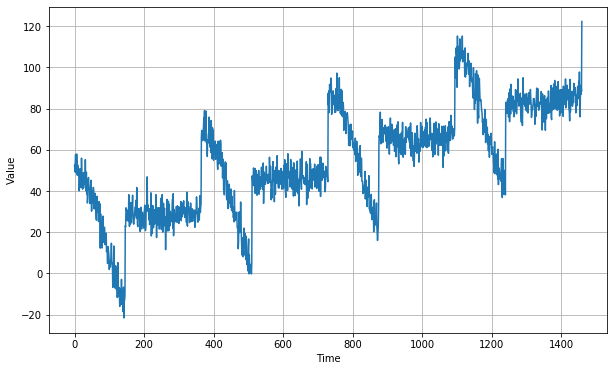

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [8]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [9]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

## LSTM RNN Forecast

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                     batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 0s 14ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 14ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 13ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 13ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

[1e-08, 0.0001, 0, 30]

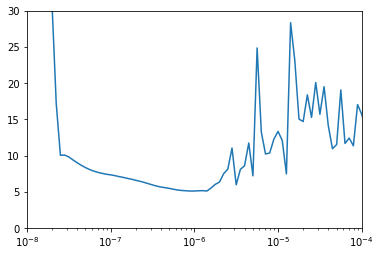

In [13]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

Looks like the best learning rate is osmething like $10^{-6}$. Let's build the real thing now.

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, stateful=True,
                     batch_input_shape=[1, None, 1]),
    keras.layers.LSTM(100, return_sequences=True, stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[reset_states, model_checkpoint, early_stopping])

Epoch 1/500
33/33 [==============================] - 1s 36ms/step - loss: 28.6094 - mae: 29.1047 - val_loss: 9.6467 - val_mae: 10.1364
Epoch 2/500
33/33 [==============================] - 1s 16ms/step - loss: 15.2767 - mae: 15.7682 - val_loss: 10.4999 - val_mae: 10.9875
Epoch 3/500
33/33 [==============================] - 1s 16ms/step - loss: 11.0131 - mae: 11.5051 - val_loss: 12.7499 - val_mae: 13.2423
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 11.7909 - mae: 12.2823 - val_loss: 10.0053 - val_mae: 10.4976
Epoch 5/500
33/33 [==============================] - 1s 17ms/step - loss: 14.9409 - mae: 15.4356 - val_loss: 8.4592 - val_mae: 8.9456
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 10.2205 - mae: 10.7120 - val_loss: 8.1304 - val_mae: 8.6217
Epoch 7/500
33/33 [==============================] - 1s 15ms/step - loss: 6.1974 - mae: 6.6794 - val_loss: 9.8126 - val_mae: 10.3063
Epoch 8/500
33/33 [==============================] - 1s 

In [22]:
model = keras.models.load_model("my_checkpoint.h5")

In [23]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, split_time-1:-1, 0]

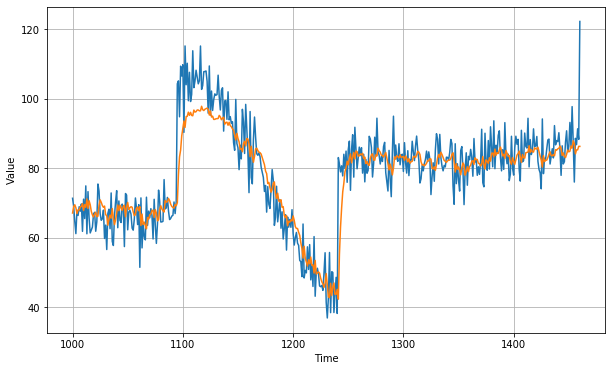

In [24]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [25]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.224281